In this notebook we use OpeNDAP to extract time series data at a single location of interest, then plot this data. This extraction process can also be done with the AIMS eReefs data extraction tool (https://extraction.ereefs.aims.gov.au/). If you which to perform bigger extractions then we recommend using this tool instead of this process outlined in this example. 

In [21]:
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import os
import datetime
import pandas as pd
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

The first part of the process is to choose the OPeNDAP end point on the AIMS eReefs THREDD server. You can view the products here: http://thredds.ereefs.aims.gov.au/thredds/s3catalogue/aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/catalog.html
Connect to the OpeNDAP endpoint for the specified month and year. At this stage there is no grouped OpenDAP service for the entire time series and so this script only works for looking at a single month of data. Hopefully this can be improved in th future.

In [34]:
# Connect to the OpeNDAP endpoint for the specified. At this stage there is no grouped OpenDAP service for 
month = 3
year = 2016
netCDF_datestr = str(year)+'-'+format(month, '02')
netCDF_datestr

'2016-03'

In [35]:
# OPeNDAP URL to file "EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-2010-09.nc". Hydrodynamic 4km model, daily data for the month September 2010
inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"

nc_data = Dataset(inputFile, 'r')
nc_data.title

# To find a list of the variables uncomment the next line:
# nc_data.variables

'eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 daily aggregation'

Work out the range of the data

In [36]:
lons = nc_data.variables['longitude'][:]
max_lon = max(lons)
min_lon = min(lons) 
lats = nc_data.variables['latitude'][:]
max_lat = max(lats)
min_lat = min(lats)
grid_lon = lons.size
grid_lat = lats.size
print("Grid bounds, Lon: "+str(min_lon)+" - "+str(max_lon)+" Lat:"+str(min_lat)+" - "+str(max_lat))
print("Grid size is: "+str(grid_lon)+" x "+str(grid_lat))

Grid bounds, Lon: 142.168788 - 156.868788 Lat:-28.696022 - -7.036022
Grid size is: 491 x 723


Find the closest index to the location of interest

In [37]:
# Davies reef
lat = -18.82
lon = 147.64
selectedLatIndex = round((lat-min_lat)/(max_lat-min_lat)*grid_lat)
selectedLonIndex = round((lon-min_lon)/(max_lon-min_lon)*grid_lon)
print("Grid position of location: "+str(selectedLatIndex)+", "+str(selectedLonIndex))

Grid position of location: 330, 183


Extract the values over time at this location

In [38]:
selectedDepthIndex = 15 # -1.5m

# Time, Depth, Lat, Lon
dailyTemp = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
print(dailyTemp[0:5])

[30.920511 29.575703 29.260357 29.239874 29.283915]


Get the time series. Note that the time values are stored as the number of days since 1990-01-01 00:00:00 +10. As a result we need to convert these to datetime objects and do a bit of calendar math to workout the actual dates.

In [39]:
times = nc_data.variables['time'][:]
print(times[0:5])

[9556. 9557. 9558. 9559. 9560.]


In [40]:
# Convert the days since the 1990 origin into Pandas dates for plotting
dates = pd.to_datetime(times,unit='D',origin=pd.Timestamp('1990-01-01'))


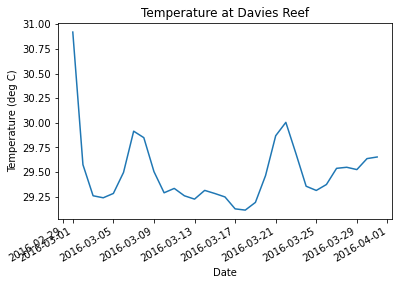

In [41]:
plt.plot(dates,dailyTemp)

# Set the axes formating to show the dates on an angle on the current figure (gcf)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Temperature (deg C)')
plt.title('Temperature at Davies Reef')
plt.show()